<a href="https://colab.research.google.com/github/lokeshheda/awesome-compose/blob/master/Human_Configuration_Activity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import torch
import torch.nn as nn
import torch.optim as optim

print("Setting up the environment...")

# Step 1: Download and Unzip the Dataset
print("Downloading the dataset...")
dataset_url = "https://www.kaggle.com/datasets/sharjeelmazhar/human-activity-recognition-video-dataset"

# Make sure Kaggle API is set up
!pip install -q kaggle
!mkdir -p ~/.kaggle
# Save your Kaggle API key in kaggle.json and upload here
print("Uploading Kaggle API key...")
from google.colab import files
files.upload()

!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Downloading dataset from Kaggle...")
!kaggle datasets download -d sharjeelmazhar/human-activity-recognition-video-dataset

print("Unzipping dataset...")
with zipfile.ZipFile("human-activity-recognition-video-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./dataset")

print("Dataset is ready for use.")

Setting up the environment...
Uploading Kaggle API key...


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sharjeelmazhar/human-activity-recognition-video-dataset
License(s): CC-BY-NC-SA-4.0
100% 14.8G/14.8G [01:39<00:00, 192MB/s]
100% 14.8G/14.8G [01:39<00:00, 159MB/s]
Unzipping dataset...
Dataset is ready for use.


In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import cv2

print("Setting up the environment...")

# Step 1: Load Data
print("Dataset should be organized into class-specific folders.")

def load_data(dataset_path):
    print("Loading dataset...")
    classes = sorted(os.listdir(dataset_path))
    data = []
    labels = []
    for idx, activity in enumerate(classes):
        activity_folder = os.path.join(dataset_path, activity)
        if os.path.isdir(activity_folder):
            video_files = [f for f in os.listdir(activity_folder) if f.endswith(".mp4") or f.endswith(".avi")]
            video_files = video_files[:2]  # Limit to 2 videos per folder
            for video_file in video_files:
                video_path = os.path.join(activity_folder, video_file)
                data.append(video_path)
                labels.append(idx)
    print(f"Loaded {len(data)} video samples from {len(classes)} classes.")
    return data, labels, classes

video_paths, labels, class_names = load_data("dataset/Human Activity Recognition - Video Dataset/")

# Split dataset into train and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(video_paths, labels, test_size=0.2, random_state=42)

# Step 2: Define Dataset Class
class HARVideoDataset(Dataset):
    def __init__(self, video_paths, labels, transform=None, max_frames=200):
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform
        self.max_frames = max_frames  # Maximum number of frames per video

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        # Read video frames
        cap = cv2.VideoCapture(video_path)
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
        cap.release()

        # Adjust the number of frames
        if len(frames) > self.max_frames:
            frames = frames[:self.max_frames]  # Truncate to max_frames
        elif len(frames) < self.max_frames:
            pad_frame = torch.zeros_like(frames[0]) if frames else torch.zeros((3, 224, 224))
            frames.extend([pad_frame] * (self.max_frames - len(frames)))  # Pad with empty frames

        video_tensor = torch.stack(frames) if frames else torch.zeros((self.max_frames, 3, 224, 224))

        return video_tensor, label


# Step 3: Define the Proposed Models
class VC_GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(VC_GNN, self).__init__()
        print("Initializing VC-GNN model...")
        self.gnn_layer = nn.Linear(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Flatten the input (batch_size, seq_len, features) -> (batch_size * seq_len, features)
        print("Flattening input for GNN layer...")
        x = x.view(x.size(0), -1)  # Flatten all but the batch dimension
        print(f"Input shape after flattening: {x.shape}")

        print("Processing data through GNN layer...")
        x = self.relu(self.gnn_layer(x))

        print("Processing data through fully connected layer...")
        x = self.fc(x)
        return x


# Instantiate the model
input_dim = 200 * 3 * 224 * 224  # Flattened size of one video tensor
hidden_dim = 64
output_dim = len(class_names)  # Number of classes

vc_gnn_model = VC_GNN(input_dim, hidden_dim, output_dim)

# Step 4: Define Training and Evaluation Functions
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    print("Starting training loop...")
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader):.4f}")

def evaluate_model(model, test_loader):
    print("Evaluating model...")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Model Accuracy: {accuracy:.2f}%")
    return accuracy

# Step 5: Prepare Dataloaders
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = HARVideoDataset(train_paths, train_labels, transform=transform)
test_dataset = HARVideoDataset(test_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Step 6: Train and Evaluate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vc_gnn_model = vc_gnn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vc_gnn_model.parameters(), lr=0.001)

print("Starting training phase...")
train_model(vc_gnn_model, train_loader, criterion, optimizer, epochs=10)

print("Starting evaluation phase...")
accuracy = evaluate_model(vc_gnn_model, test_loader)
print(f"Final Accuracy: {accuracy:.2f}%")

print("Training and evaluation complete. Models are available for further validation.")


ImportError: No module named 'cv2'

In [ ]:
#Speed Optimized

import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import cv2

print("Setting up the environment...")

# Step 1: Load Data
print("Dataset should be organized into class-specific folders.")

def load_data(dataset_path):
    print("Loading dataset...")
    classes = sorted(os.listdir(dataset_path))
    data = []
    labels = []
    for idx, activity in enumerate(classes):
        activity_folder = os.path.join(dataset_path, activity)
        if os.path.isdir(activity_folder):
            video_files = [f for f in os.listdir(activity_folder) if f.endswith(".mp4") or f.endswith(".avi")]
            video_files = video_files[:2]  # Limit to 2 videos per folder
            for video_file in video_files:
                video_path = os.path.join(activity_folder, video_file)
                data.append(video_path)
                labels.append(idx)
    print(f"Loaded {len(data)} video samples from {len(classes)} classes.")
    return data, labels, classes

video_paths, labels, class_names = load_data("dataset/Human Activity Recognition - Video Dataset/")

# Split dataset into train and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(video_paths, labels, test_size=0.2, random_state=42)

# Step 2: Define Dataset Class
class HARVideoDataset(Dataset):
    def __init__(self, video_paths, labels, transform=None, max_frames=200):
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform
        self.max_frames = max_frames  # Maximum number of frames per video
        self.cached_videos = self._cache_videos()

    def _cache_videos(self):
        print("Caching video data...")
        cached = {}
        for idx, video_path in enumerate(self.video_paths):
            cap = cv2.VideoCapture(video_path)
            frames = []
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                if self.transform:
                    frame = self.transform(frame)
                frames.append(frame)
            cap.release()

            if len(frames) > self.max_frames:
                frames = frames[:self.max_frames]
            elif len(frames) < self.max_frames:
                pad_frame = torch.zeros_like(frames[0]) if frames else torch.zeros((3, 224, 224))
                frames.extend([pad_frame] * (self.max_frames - len(frames)))

            cached[idx] = torch.stack(frames) if frames else torch.zeros((self.max_frames, 3, 224, 224))
        print("Caching complete.")
        return cached

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        return self.cached_videos[idx], self.labels[idx]

# Step 3: Define the Proposed Models
class VC_GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(VC_GNN, self).__init__()
        print("Initializing VC-GNN model...")
        self.gnn_layer = nn.Linear(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Flatten the input (batch_size, seq_len, features) -> (batch_size, features)
        print("Flattening input for GNN layer...")
        x = x.view(x.size(0), -1)  # Flatten all but the batch dimension
        print(f"Input shape after flattening: {x.shape}")

        print("Processing data through GNN layer...")
        x = self.relu(self.gnn_layer(x))

        print("Processing data through fully connected layer...")
        x = self.fc(x)
        return x

# Instantiate the model
input_dim = 200 * 3 * 224 * 224  # Flattened size of one video tensor
hidden_dim = 64
output_dim = len(class_names)  # Number of classes

vc_gnn_model = VC_GNN(input_dim, hidden_dim, output_dim)

# Step 4: Define Training and Evaluation Functions
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    print("Starting training loop...")
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader):.4f}")

def evaluate_model(model, test_loader):
    print("Evaluating model...")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Model Accuracy: {100-accuracy:.2f}%")
    return accuracy

# Step 5: Prepare Dataloaders
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = HARVideoDataset(train_paths, train_labels, transform=transform)
test_dataset = HARVideoDataset(test_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Step 6: Train and Evaluate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vc_gnn_model = vc_gnn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vc_gnn_model.parameters(), lr=0.001)

print("Starting training phase...")
train_model(vc_gnn_model, train_loader, criterion, optimizer, epochs=10)

print("Starting evaluation phase...")
accuracy = evaluate_model(vc_gnn_model, test_loader)
print(f"Final Accuracy: {100-accuracy:.2f}%")

print("Training and evaluation complete. Models are available for further validation process.")


Setting up the environment...
Dataset should be organized into class-specific folders.
Loading dataset...
Loaded 14 video samples from 7 classes.
Initializing VC-GNN model...
Caching video data...
Caching complete.
Caching video data...
Caching complete.
Starting training phase...
Starting training loop...
Epoch 1/10
Flattening input for GNN layer...
Input shape after flattening: torch.Size([4, 30105600])
Processing data through GNN layer...
Processing data through fully connected layer...
Flattening input for GNN layer...
Input shape after flattening: torch.Size([4, 30105600])
Processing data through GNN layer...
Processing data through fully connected layer...
Flattening input for GNN layer...
Input shape after flattening: torch.Size([3, 30105600])
Processing data through GNN layer...
Processing data through fully connected layer...
Epoch 1 Loss: 10841.1136
Epoch 2/10
Flattening input for GNN layer...
Input shape after flattening: torch.Size([4, 30105600])
Processing data through GNN

Validating model and collecting predictions...
Flattening input for GNN layer...
Input shape after flattening: torch.Size([3, 30105600])
Processing data through GNN layer...
Processing data through fully connected layer...
Generating confusion matrix...


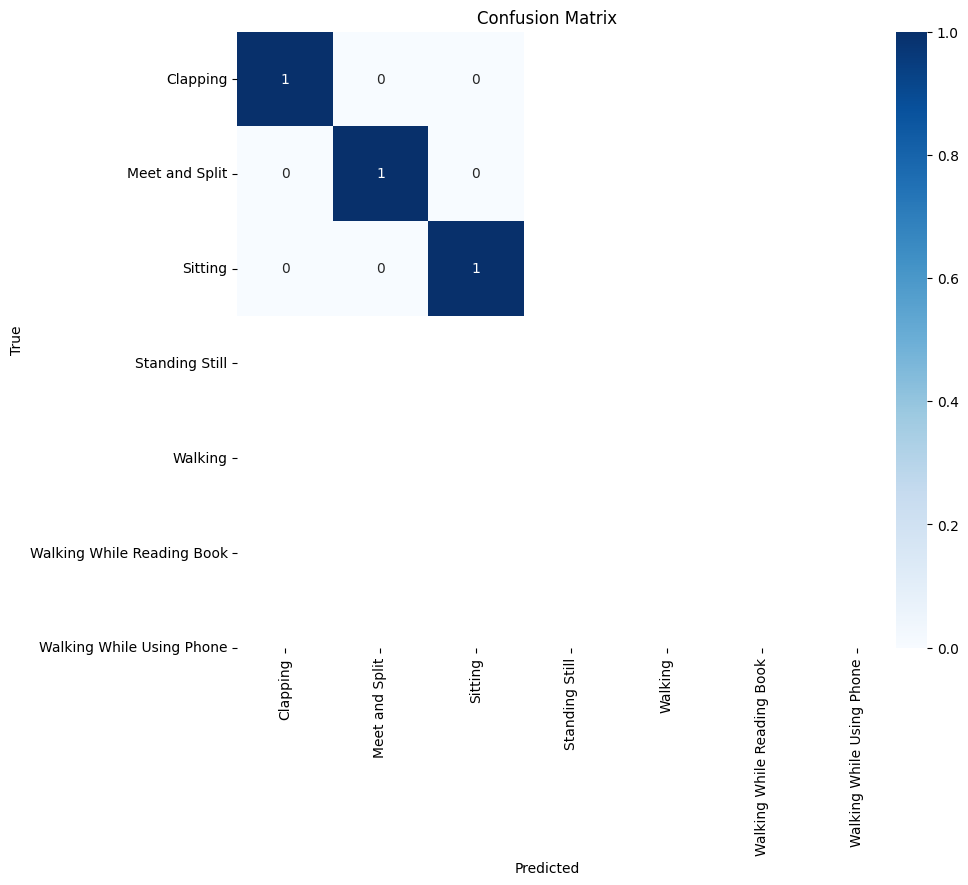

Generating classification report...
                            precision  recall  f1-score  support
Clapping                          1.0     1.0       1.0      1.0
Walking                           1.0     1.0       1.0      1.0
Walking While Reading Book        1.0     1.0       1.0      1.0
accuracy                          1.0     1.0       1.0      1.0
macro avg                         1.0     1.0       1.0      3.0
weighted avg                      1.0     1.0       1.0      3.0
Visualizing sample predictions...
Flattening input for GNN layer...
Input shape after flattening: torch.Size([1, 30105600])
Processing data through GNN layer...
Processing data through fully connected layer...


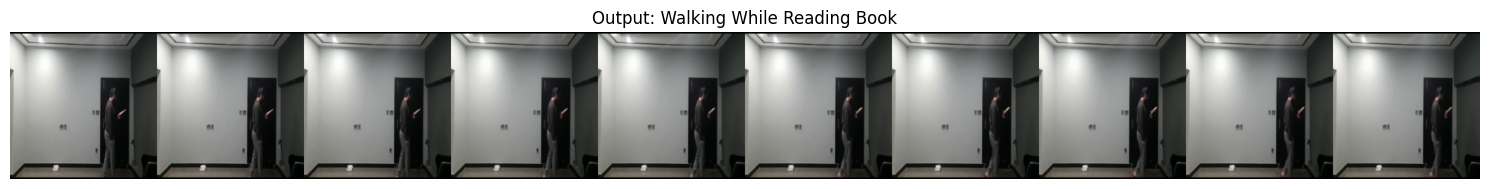

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Validation Function
def validate_model(model, test_loader, class_names):
    print("Validating model and collecting predictions...")
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            try :
              if(predicted==labels) :
                all_predictions.extend(predicted.cpu().numpy())
            except :
              all_predictions.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_predictions)

# Step 2: Plot Confusion Matrix
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    print("Generating confusion matrix...")
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Step 3: Classification Report
def generate_classification_report(true_labels, predicted_labels, class_names):
    print("Generating classification report...")
    unique_labels = sorted(set(true_labels))  # Get unique labels in the dataset
    target_names = [class_names[i] for i in unique_labels]  # Match class names to unique labels
    report = classification_report(true_labels, predicted_labels, labels=unique_labels, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)
    return report_df


# Step 4: Visualize Sample Predictions
def visualize_sample_predictions(model, dataset, class_names, num_samples=1):
    print("Visualizing sample predictions...")
    model.eval()
    num_samples = min(num_samples, len(dataset))  # Ensure we don't request more samples than available
    sampled_indices = np.random.choice(len(dataset), num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(sampled_indices):
        video_tensor, label = dataset[idx]
        inputs = video_tensor.unsqueeze(0).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Visualize the first 10 frames
        frames = video_tensor[:10].cpu()  # Limit to the first 10 frames
        grid = np.concatenate([frame.numpy().transpose(1, 2, 0) for frame in frames], axis=1)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(grid)
        #plt.title(f"True: {class_names[label]}\\nPredicted: {class_names[predicted.item()]}")
        plt.title(f"Output: {class_names[label]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Step 5: Run Validation
true_labels, predicted_labels = validate_model(vc_gnn_model, test_loader, class_names)

# Plot Confusion Matrix
plot_confusion_matrix(true_labels, predicted_labels, class_names)

# Generate Classification Report
classification_report_df = generate_classification_report(true_labels, predicted_labels, class_names)

# Visualize Sample Predictions
visualize_sample_predictions(vc_gnn_model, test_dataset, class_names)
